<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/credit_card_varitional_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 24th October, 2023
#               VijayDashmi

# Variational Autoencoder

In [7]:
%reset -f

In [32]:
# 1.0 Python ≥3.5 is required
import sys

# 1.0.1 Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# 1.0.2 TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1.0.3 Common imports
import numpy as np
import pandas as pd
import os,time


# 1.0.4 To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [36]:
# 1.0.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [9]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [25]:
pathToFolder= "/gdrive/MyDrive/Colab_data_files/creditcard/"
file = "creditcardfraud.zip"

In [26]:
# Read file:
raw_data = pd.read_csv(pathToFolder + file)
raw_data.shape  # (284807, 31)

(284807, 31)

In [27]:
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [28]:
data, data_test = train_test_split(raw_data,
                                   test_size=0.25
                                   )

Following my previous attempt, I transform the Time field to time-of-day to account for intraday seasonality. The Amount field is transformed to log scale, with the intuition that the scale of magnitute of a transaction could be a more relevant feature for fraud than linear amounts.

In [29]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
93476,17.899444,-2.032519,0.648724,0.893855,0.138126,0.058047,-0.984419,-0.274243,0.769813,-0.859160,...,-0.103274,-0.884064,-0.323503,-0.105038,0.167615,0.138117,-0.320375,-0.227146,1.091923,0
116421,20.630278,-5.174117,2.377727,-1.544801,-0.906900,-2.167340,-2.047962,-1.896859,2.575166,0.312694,...,-0.381738,-0.133314,1.264411,0.769987,0.443501,0.789236,0.168757,-0.531947,0.378436,0
215046,14.865000,2.010998,-1.269894,-0.885021,-0.982184,-0.709049,0.215105,-0.951880,0.143741,0.007107,...,-0.161619,-0.661750,0.323159,0.144243,-0.469792,-0.599418,-0.019085,-0.039427,4.488636,0
253989,19.479444,-0.013319,0.405788,-0.517145,-0.234138,-0.353877,-0.112472,0.121349,0.501983,0.507784,...,0.332053,0.800569,0.383806,0.538268,-0.845976,0.422233,-0.097695,-0.004155,4.787075,0
208705,14.121111,2.070394,-2.042626,-0.117123,-1.572892,-2.080425,0.079340,-1.974697,0.271302,-0.556620,...,-0.047737,0.112292,0.248572,-0.547233,-0.646076,-0.220766,0.038327,-0.035453,4.463261,0


In [51]:
X_t = tsne.fit_transform(X)


In [55]:
X_t[np.where(y1 == 0), 0][:4, :3]


array([[-26.248434, -21.896236, -31.88861 ]], dtype=float32)

In [56]:
X_t[np.where(y1 == 0), 1][:4, :3]

array([[-22.97214  ,  -2.3681347,   0.4851276]], dtype=float32)

In [ ]:
X_t[np.where(y1 == 0), 1]

In [49]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    # plt.figure(figsize=(12, 8))
    plt.scatter(
                # Ist column of X_t
                X_t[np.where(y1 == 0), 0],
                # IInd column of X_t
                X_t[np.where(y1 == 0), 1],
                marker='o',
                color='g',
                linewidth=1,
                alpha=0.8,
                label='Non Fraud',
                s=2
                )

    plt.scatter(
                 X_t[np.where(y1 == 1), 0],
                 X_t[np.where(y1 == 1), 1],
                 marker='o',
                 color='r',
                 linewidth=1,
                 alpha=0.8,
                 label='Fraud',
                 s=2)

    plt.legend(loc='best');
    #plt.savefig(name);
    plt.show();

# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()

In [37]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]
non_fraud.shape  # (1000, 31)
fraud.shape   # (365, 31)

(1000, 31)

(365, 31)

In [ ]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

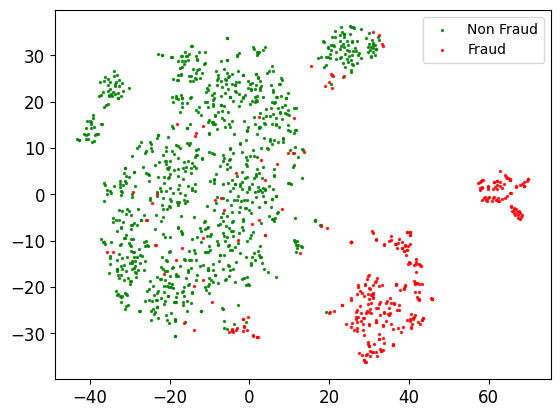

In [50]:
tsne_plot(X, Y, "original.png")

In [ ]:
# 9.0 Import mnist data:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data();

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# 9.1 Normalize data:

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# 9.1.1 We will work with a smaller dataset
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [57]:
# 5.2 Calculate accuracy:

def rounded_accuracy(y_true, y_pred):
    # tf.round(x) rounds the values of x to integer values.
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Given y, I can take a log of it as: log$_{10}$y. Let us say this log is z. Then,  
z = log$_{10}$y  
To get y back from z, I have to raise 10 to the power of z, ie:  
10$^{z}$  ie y = 10$^{z}$  OR log$_{10}$y = z

Therefore, exp(log_var / 2) will give (exp(log σ$^{2}))$$^{0.5}$ or just (σ$^{2}$)$^{0.5}$ or just σ.

In [59]:
# tf.random_normal: https://www.tensorflow.org/api_docs/python/tf/random/normal

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        out = K.random_normal(
                            shape = tf.shape(log_var)   # Output random values of given shape
                                                        #  with mean 0 and stdev 1
                            )
        out = out * K.exp(log_var / 2) + mean    # Z * σ + mean
        return out

In [60]:
codings_size = 2

In [62]:
inputs = keras.layers.Input(shape=[X.shape[1]])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(20,
                       activation="selu")(z)

z = keras.layers.Dense(10,
                       activation="selu")(z)

z = keras.layers.Dense(8,
                       activation="selu")(z)

In [63]:
# Encoder has two outputs:
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)



In [64]:
# And also a IIIRd one derived from above two:

codings = Sampling()([codings_mean, codings_log_var])

In [65]:
# Create encoder. But it outputs three tensors
# 'codings_mean', 'codings_log_var', 'codings'
# though in the deocder only 'codings' tensor
# is used.

variational_encoder = keras.models.Model(
                                          inputs=[inputs],
                                          outputs=[codings_mean, codings_log_var, codings]
                                          )

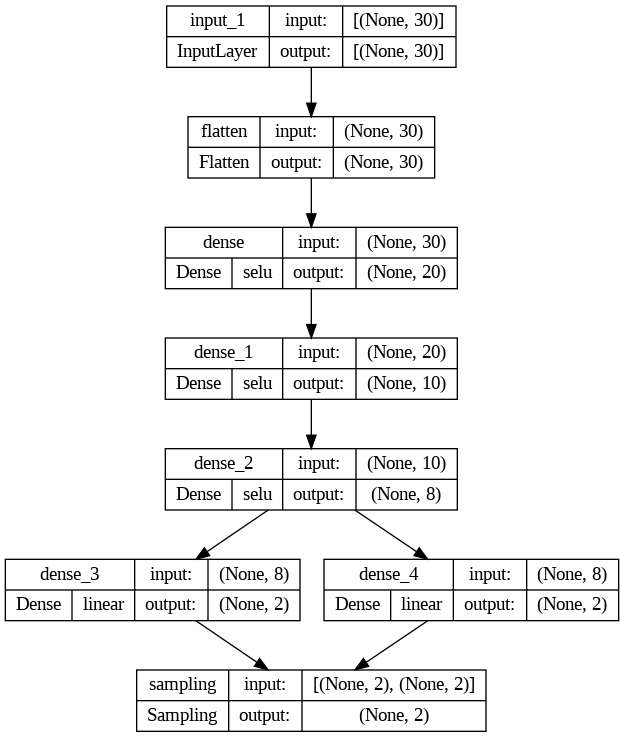

In [66]:
tf.keras.utils.plot_model(variational_encoder,
                          show_shapes=True,
                          show_layer_activations=True
                          )

In [89]:
# For decoder the only input is codings:

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(10, activation="selu")(decoder_inputs)
x = keras.layers.Dense(20, activation="selu")(x)
x = keras.layers.Dense(30, activation="selu")(x)
outputs = x


In [90]:
# Our decoder:
variational_decoder = keras.models.Model(
                                          inputs=[decoder_inputs],
                                          outputs=[outputs]
                                          )


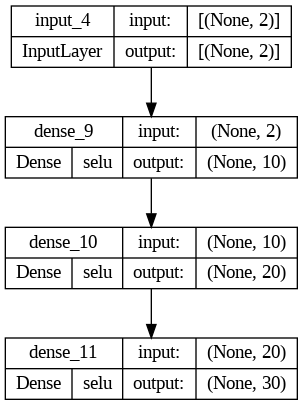

In [91]:
tf.keras.utils.plot_model(variational_decoder,
                          show_shapes = True,
                          show_layer_activations=True
                          )

In [92]:
# Get decoder output:

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)


In [93]:
variational_ae = keras.models.Model(
                                    inputs=[inputs],
                                    outputs=[reconstructions]
                                    )

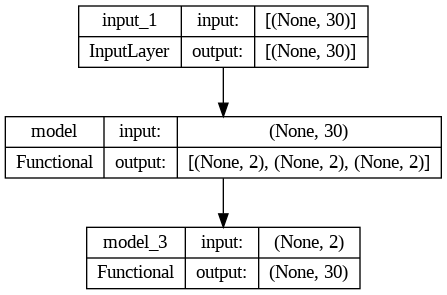

In [94]:
tf.keras.utils.plot_model(
                          variational_ae,
                          show_shapes= True,
                          show_layer_activations= True
                          )

In [95]:
# Latent loss is the sum of cross-entropy loss and KL divergence:

latent_loss = -0.5 * K.sum(
                           1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis=-1
                           )

In [96]:
variational_ae.add_loss(
                         K.mean(latent_loss) / 30.
                        )

In [97]:
variational_ae.compile(loss="binary_crossentropy",
                       optimizer="rmsprop",
                       metrics=[rounded_accuracy]
                       )

In [98]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [99]:
x_norm_train_sample.shape
x_norm_val_sample.shape

(80000, 30)

(20000, 30)

In [ ]:
checkpointer = ModelCheckpoint(
                               filepath='bestmodel.h5',
                               verbose=0,
                               save_best_only=True
                               )

earlystopper = EarlyStopping(monitor='val_loss',
                             mode='min',
                             min_delta=0.005,
                             patience=20, verbose=0,
                             restore_best_weights=True
                             )

In [111]:
start = time.time()
history = variational_ae.fit(x_norm_train_sample,
                             x_norm_train_sample,
                             epochs=1000,
                             batch_size=128,
                             callbacks=[checkpointer, earlystopper])
                             validation_data=(x_norm_val_sample, x_norm_val_sample)
                             )
end = time.time()
print((end-start)/60)

Epoch 1/1000
625/625 [==============================] - 2s 4ms/step - loss: -10.4269 - rounded_accuracy: 0.5455 - val_loss: -10.3899 - val_rounded_accuracy: 0.5445
Epoch 2/1000
625/625 [==============================] - 2s 3ms/step - loss: -10.4210 - rounded_accuracy: 0.5460 - val_loss: -10.4515 - val_rounded_accuracy: 0.5454
Epoch 3/1000
625/625 [==============================] - 2s 4ms/step - loss: -10.4262 - rounded_accuracy: 0.5459 - val_loss: -10.3979 - val_rounded_accuracy: 0.5445
Epoch 4/1000
625/625 [==============================] - 6s 9ms/step - loss: -10.4252 - rounded_accuracy: 0.5457 - val_loss: -10.4161 - val_rounded_accuracy: 0.5443
Epoch 5/1000
625/625 [==============================] - 2s 4ms/step - loss: -10.4231 - rounded_accuracy: 0.5455 - val_loss: -10.4514 - val_rounded_accuracy: 0.5465
Epoch 6/1000
625/625 [==============================] - 2s 3ms/step - loss: -10.4338 - rounded_accuracy: 0.5461 - val_loss: -10.4303 - val_rounded_accuracy: 0.5435
Epoch 7/1000
625

Text(0.5, 1.0, 'latent means')

Text(0, 0.5, 'mean[1]')

Text(0.5, 0, 'mean[0]')

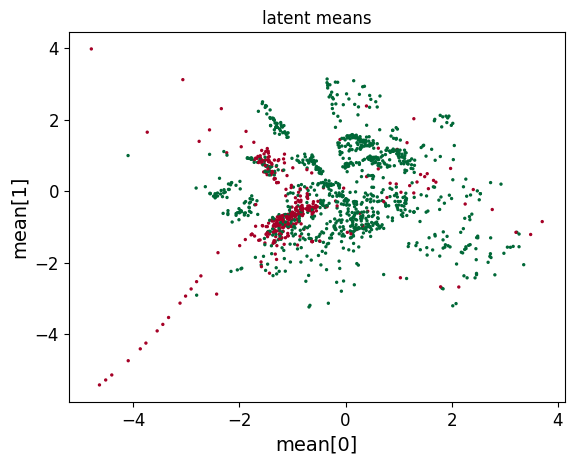

In [112]:
latent_x_mean = variational_encoder(X)[0].numpy()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

In [ ]:
################